[long-term] Study the funnels’ high-variance regions & what causes those features; <br>
-> By examining the correlations between MI(Te) and [RT instability] MI(ρ_gas) and potentially MI(Pg) and [large-scale mag interchange] MI(B) to see if MI(Te) has a higher correlation with one of the two components -> tell us which one is the more dominant mechanism <br>
$\space \space$-->  assume those mechanisms act on every part of the accretion flow and funnel initially ("symmetry"), study one side (say, left side) of the accretion flow and funnel; "chunks" of B in contrast with grid values of ρ_gas and Pg to represent large scale and local scale!

Numerical simulation method:
Correlation matrix: Te of rho, Pg, Pmag, so 3 matrices in total for each set
How to do a multi-variable correlation analysis based on correlation matrices? 

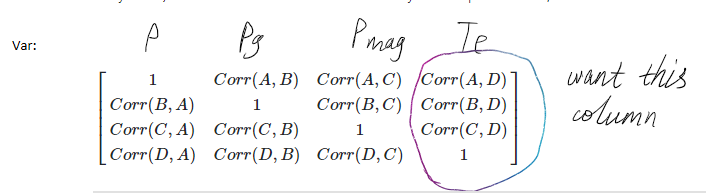

In [ ]:
from toolz import valmap

import h5py
import pyharm

import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

from scipy import signal

In [ ]:
i0 = 5010 # initial  frame
i1 = 5061 # 1 + last frame

fmt = 'torus.out0.{:05d}.h5'

qualities = ['RHO', 'Pg', 'bsq', 'beta', 'Theta', 'Thetae']

In [ ]:
# some constants
cl = 29979245800.0 # speed of light in cgs
mp = 1.67262171e-24
kb = 1.3806505e-16
mu = 1.

In [ ]:
def fname(i, src): # closure on `src` and `fmt`
    return (src+fmt).format(i)

In [ ]:
src_ma_10M = '/xdisk/chanc/share/GRMHD_dt10M/Ma+0.94_w5/'
src_sa_10M = '/xdisk/chanc/share/GRMHD_dt10M/Sa+0.94_w5/'

src_ma_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Ma+0.94_w5/'
src_sa_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Sa+0.94_w5/'

dump0 = pyharm.load_dump(fname(i0, src_ma_10M))
R_low = 1.
R_high = [1, 10, 40, 160]
# first row of SANE model params

In [ ]:
def get_dumps(i0, i1, src, step=1):
    dumps = {}
    for i in range(i0, i1, step):
        dumps[str(i)] = pyharm.load_dump(fname(i, src))
    return dumps

In [ ]:
def average(irange, dumps, keys):
    s = {k:0 for k in keys}
    for i in irange:
        # print('i:', i)
        # Because data I/O is expensive, we load the data once ...
        d = dumps[str(i)].cache
        # print('d:', d)
        # ... and then sum over multiple keys
        for k in keys:
            s[k] += d[k] # i.e.: s[key1] = file1[key1] + file2[key1] + file3[key1] + ...
            # print('s[k]:', s[k])
            # print('d[k]', d[k])
    print('finish average calculation.')
    return valmap(lambda v: v/len(irange), s) # return an average of variables from the files read in

In [ ]:
# works; returns an array of arrays with numerical values
def variance(irange, dumps, quality='Te'):
    """
    quality: str, the physical quality whose variance values we want (e.g. 'Te' for electron temperature)
    dumps: dictionary, all the dump files read in
    """
    key = 'var' + quality
    ss = {key: 0}
    for i in irange:
        d = dumps[str(i)].cache
        ss[key] += (d[quality]-d['avg' + quality])**2
    for i in irange:
        dumps[str(i)].cache[key] = ss[key]
    print('finish variance & standard deviation calculation\'s loop.')
    # return valmap(lambda v: v/len(irange), ss)

$\gamma = \frac{4}{3}$, $x_{e} = \frac{1}{4}$, so ions:electrons = 3:1 (y=1, z=3; $\gamma_{i}=\gamma=\frac{4}{3}, \gamma_e = \gamma + x_{e} / (1 - x_{e})(5/3 - \gamma) = \frac{7}{3}$) <br> 
$Const = m_{p}(\gamma_{e}-1)(\gamma_{i}-1)$ <br> 
$const1 = y(\gamma_{i}-1)$ <br>
$const2 = z(\gamma_{e}-1)$ <br>
$const3 = k_{B}(\gamma-1)$

In [ ]:
def get_statistics(dumps, quality):
    """
    dumps: the dumps' dictionary in the format of dumps={'5010':arr1, '5011':arr2, etc}
    quality: string, the quality whose statistics we want 
    """
    print('statistics on ' + quality + ':')
    print('max ' + quality + ':')
    maximum = np.max(dumps[str(i0)].cache[quality])
    print("{:e}".format(maximum))
    print('percentile on ' + quality+ ' [25%, 75%, 90%]:')
    # percentile of the flattened grid
    percentile = np.percentile(dumps[str(i0)].cache[quality], [25, 75, 90])
    print(percentile)

## Get var(Te), var($\rho$), var(Pg), and var($P_{mag}$)

so many calculations...memory issue

In [ ]:
def mag_pressure(dump):
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    
    dump.cache['Pmag'] = Pmag

In [ ]:
def R(dump, Rh, Rl, Pmag):
    Pg = dump['Pg']
    return Rl/(Pmag**2+Pg**2)+Rh*Pg**2/(Pmag**2+Pg**2)

In [ ]:
# electron temperature
def Te(dump, Rh, Rl, gamma):
    if gamma == 4/3:
        y = 1
        z = 3
        gamma_i = 4/3
        gamma_e = 7/3
    if gamma == 13/9:
        y = 1
        z = 2
        gamma_i = 13/9
        gamma_e = 133/36
    if gamma == 5/3:
        y = 1
        z = 1
        gamma_i = 5/3
        gamma_e = 5/3
    beta = dump['beta']
    u = dump['Pg']/(gamma-1)
    r = R(dump, Rh, Rl)
    numerator = mp*cl**2*u*(gamma_e-1)*(gamma_i-1)
    denom = kb*dump['RHO']*(y*(gamma_i-1)+r*z*(gamma_e-1))
    electron_T = numerator/ denom
    dump.cache['Te'] = electron_T
    return electron_T

### MAD

In [ ]:
dumps_ma = get_dumps(i0, i1, src_ma_10M)

In [ ]:
# get ρ
for dump in dumps_ma.values():
    dump['RHO']

In [ ]:
# var(ρ)
rho_ma_var1 = variance(range(i0, i1), dumps_ma, 'RHO')
for dump in dumps_ma.values():
    dump.cache['varRHO'] = np.squeeze(np.array(list(rho_ma_var1.values())))

In [ ]:
# get Pmag
for dump in dumps_ma.values():
    mag_pressure(dump)

In [ ]:
# var(Pmag)
Pmag_ma_var1 = variance(range(i0, i1), dumps_ma, 'Pmag')
for dump in dumps_ma.values():
    dump.cache['varPmag'] = np.squeeze(np.array(list(Pmag_ma_var1.values())))

In [ ]:
# var(Pg)
Pg_ma_var1 = variance(range(i0, i1), dumps_ma, 'Pg')
for dump in dumps_ma.values():
    dump.cache['varPg'] = np.squeeze(np.array(list(Pg_ma_var1.values())))

$R_{high}=R_{low}=1$

In [ ]:
# get Te
for dump in dumps_ma.values():
    dump.cache['Te'] = Te(dump, R_high[0], Rl, gamma=4/3)

In [ ]:
# var(Te)
Te_ma_var1 = variance(range(i0, i1), dumps_ma)
for dump in dumps_ma.values():
    dump.cache['varTe'] = np.squeeze(np.array(list(Te_ma_var1.values())))

$R_{high}=160$, $R_{low}=1$

In [ ]:
# get Te
for dump in dumps_ma.values():
    dump.cache['Te'] = Te(dump, R_high[3], Rl, gamma=4/3)

In [ ]:
# var(Te)
Te_ma_var2 = variance(range(i0, i1), dumps_ma)
for dump in dumps_ma.values():
    dump.cache['varTe'] = np.squeeze(np.array(list(Te_ma_var2.values())))

### SANE

In [ ]:
dumps_sa = get_dumps(i0, i1, src_sa_10M)

In [ ]:
# get ρ
for dump in dumps_sa.values():
    dump['RHO']

In [ ]:
# var(ρ)
rho_sa_var1 = variance(range(i0, i1), dumps_sa, 'RHO')
for dump in dumps_sa.values():
    dump.cache['varRHO'] = np.squeeze(np.array(list(rho_sa_var1.values())))

In [ ]:
# get Pmag
for dump in dumps_sa.values():
    mag_pressure(dump)

In [ ]:
# var(Pmag)
Pmag_sa_var1 = variance(range(i0, i1), dumps_sa, 'Pmag')
for dump in dumps_sa.values():
    dump.cache['varPmag'] = np.squeeze(np.array(list(Pmag_sa_var1.values())))

In [ ]:
# var(Pg)
Pg_sa_var1 = variance(range(i0, i1), dumps_sa, 'Pg')
for dump in dumps_sa.values():
    dump.cache['varPg'] = np.squeeze(np.array(list(Pg_sa_var1.values())))

$R_{high}=R_{low}=1$

In [ ]:
# get Te
for dump in dumps_sa.values():
    dump.cache['Te'] = Te(dump, R_high[0], Rl, gamma=4/3)

In [ ]:
# var(Te)
Te_sa_var1 = variance(range(i0, i1), dumps_sa)
for dump in dumps_sa.values():
    dump.cache['varTe'] = np.squeeze(np.array(list(Te_sa_var1.values())))

$R_{high}=160$, $R_{low}=1$

In [ ]:
# get Te
for dump in dumps_sa.values():
    dump.cache['Te'] = Te(dump, R_high[3], Rl, gamma=4/3)

In [ ]:
# var(Te)
Te_sa_var2 = variance(range(i0, i1), dumps_sa)
for dump in dumps_sa.values():
    dump.cache['varTe'] = np.squeeze(np.array(list(Te_sa_var2.values())))

# Correlation

## MAD

Convolve Pmag <br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html <br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

## SANE

Convolve Pmag